# Fit using sqrt and log

In [20]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [21]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['style', 'interp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = \sqrt{-\ln(a_1 + a_2x + a_3x^2)} $$ 

In [30]:
def model_function(x: float,a1: float,a2: float,a3: float):
    return np.sqrt(-np.log(a1+a2*x+a3*x**2))

In [23]:
def get_extrapol_function(model_function,a1,a2,a3):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3)
    return extrapol_funct

## Read files

In [24]:
data_path = Path("../../../data/").resolve()
file = 'all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [25]:
df_all_tc

,1/nv,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [26]:
df_params = pd.DataFrame(index=["a1","a2","a3"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

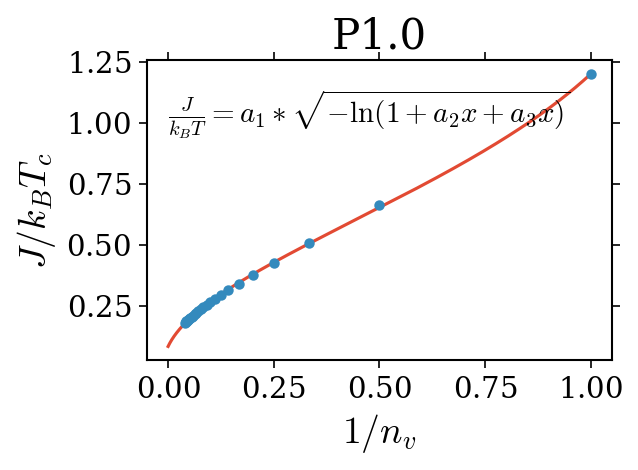

---------------------------------------------
a1: 0.9931275594209378
a2: -0.6029087702348183
a3: -0.15385681534196582
---------------------------------------------
Extrapolation:
0.08304314875840536 at 1/nv=0
1.2009957791482633 at 1/nv=1
min:0.08304314875840536 at 0.0




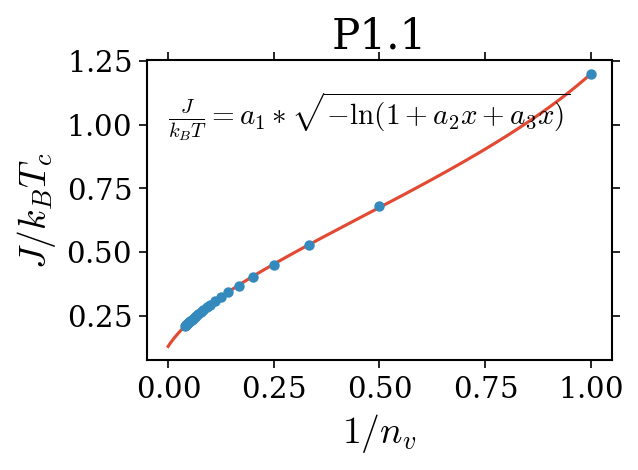

---------------------------------------------
a1: 0.9833465635609199
a2: -0.6516613520781268
a3: -0.0948768316459405
---------------------------------------------
Extrapolation:
0.12959036977399097 at 1/nv=0
1.200209976951481 at 1/nv=1
min:0.12959036977399097 at 0.0




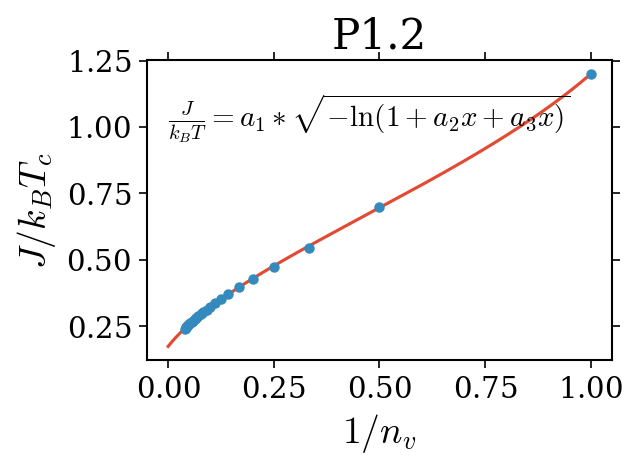

---------------------------------------------
a1: 0.969953510649567
a2: -0.6828746844260825
a3: -0.05003538983481044
---------------------------------------------
Extrapolation:
0.17466292050302676 at 1/nv=0
1.1997965989026653 at 1/nv=1
min:0.17466292050302676 at 0.0




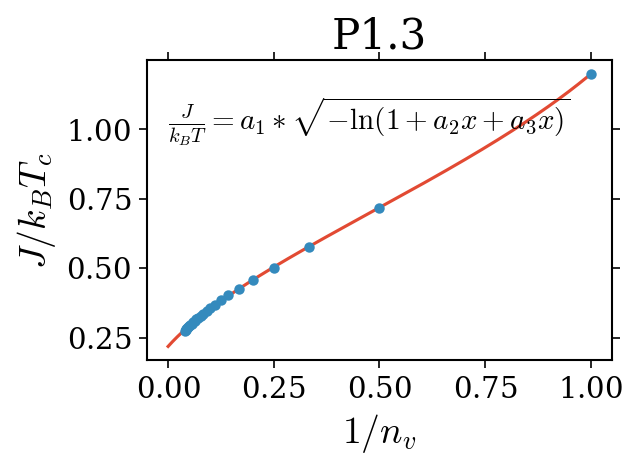

---------------------------------------------
a1: 0.9535405667186303
a2: -0.7095798616320027
a3: -0.006628066208710898
---------------------------------------------
Extrapolation:
0.21811306651039358 at 1/nv=0
1.1992883649559625 at 1/nv=1
min:0.21811306651039358 at 0.0




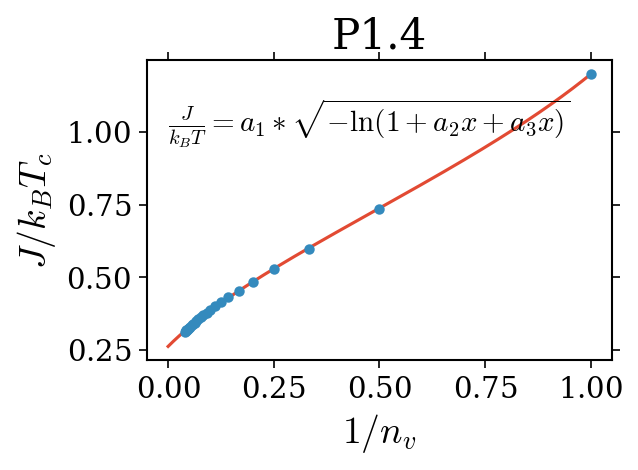

---------------------------------------------
a1: 0.9331189032948645
a2: -0.7173658183714663
a3: 0.021764045909086878
---------------------------------------------
Extrapolation:
0.26310196569486644 at 1/nv=0
1.1989643565543064 at 1/nv=1
min:0.26310196569486644 at 0.0




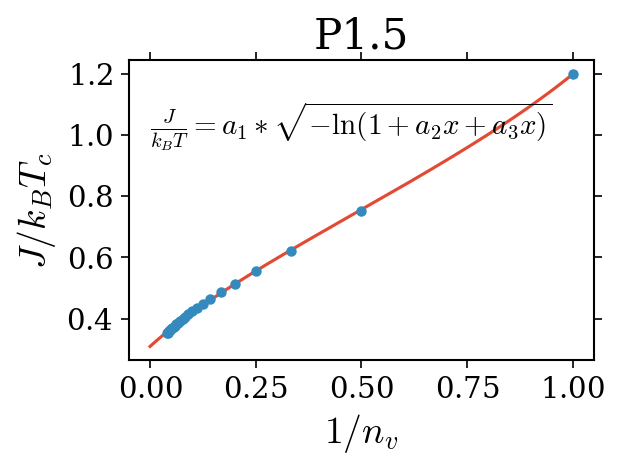

---------------------------------------------
a1: 0.9087537208063093
a2: -0.7062358890017726
a3: 0.03508460072053155
---------------------------------------------
Extrapolation:
0.3093237070132863 at 1/nv=0
1.1988146035338139 at 1/nv=1
min:0.3093237070132863 at 0.0




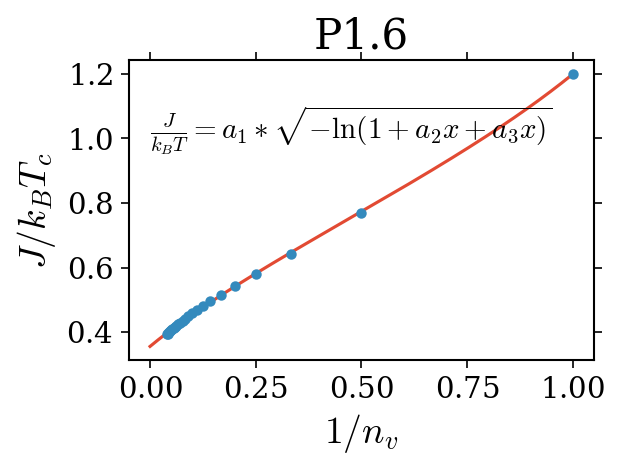

---------------------------------------------
a1: 0.8809734592993121
a2: -0.6814390785285235
a3: 0.03796643945046267
---------------------------------------------
Extrapolation:
0.35598845367959947 at 1/nv=0
1.1989929949546165 at 1/nv=1
min:0.35598845367959947 at 0.0




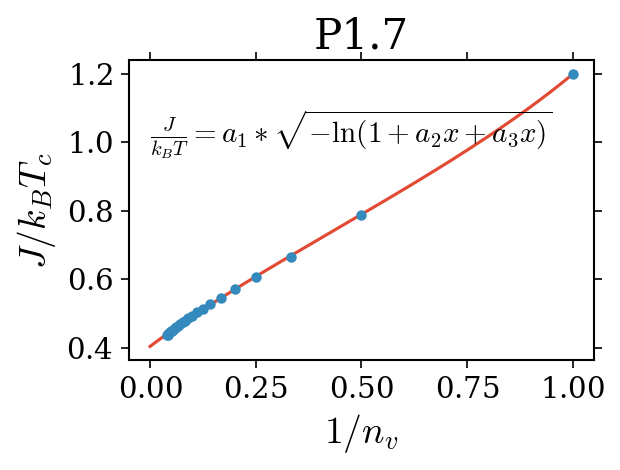

---------------------------------------------
a1: 0.8498564646055421
a2: -0.6406266188246961
a3: 0.028168801321975526
---------------------------------------------
Extrapolation:
0.4033457684506601 at 1/nv=0
1.1991724211436312 at 1/nv=1
min:0.4033457684506601 at 0.0




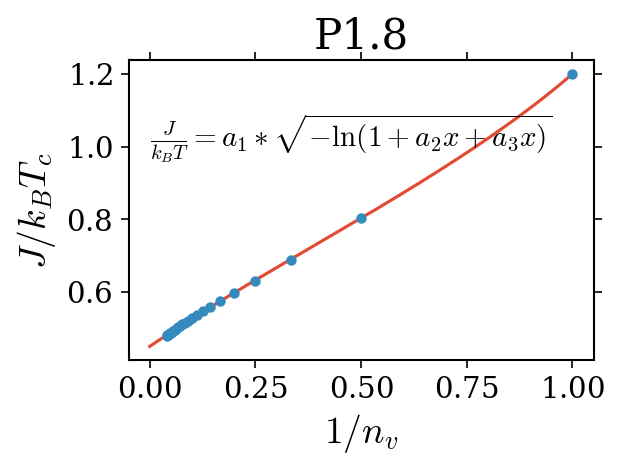

---------------------------------------------
a1: 0.8161374949993371
a2: -0.5874240318949507
a3: 0.008479856813327953
---------------------------------------------
Extrapolation:
0.4507465356923518 at 1/nv=0
1.199533148558528 at 1/nv=1
min:0.4507465356923518 at 0.0




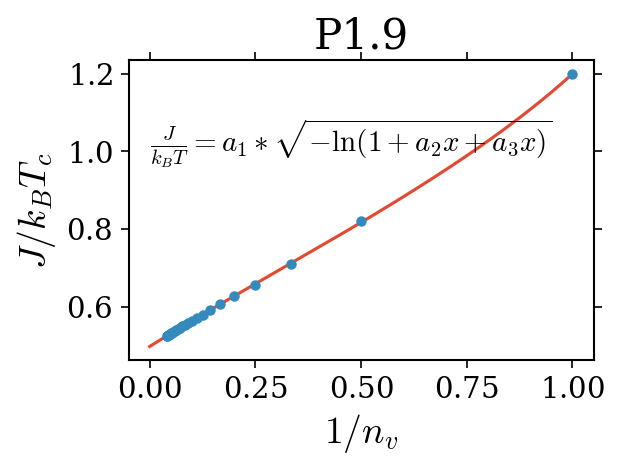

---------------------------------------------
a1: 0.7807539496381188
a2: -0.5276788708599798
a3: -0.016163888539397767
---------------------------------------------
Extrapolation:
0.49748891852717375 at 1/nv=0
1.200029138314946 at 1/nv=1
min:0.49748891852717375 at 0.0




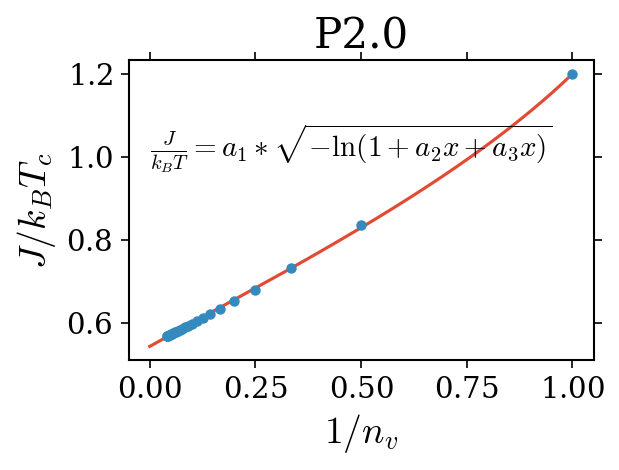

---------------------------------------------
a1: 0.7442527370824682
a2: -0.45999124342860126
a3: -0.04758814349682705
---------------------------------------------
Extrapolation:
0.5434837637450581 at 1/nv=0
1.200447565666015 at 1/nv=1
min:0.5434837637450581 at 0.0




In [31]:
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_v2'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0.01)
#         y_data = np.insert(y_data,0,0.01)

#     # for square
#     y_data = y_data**2    

    # fit 
    (a1,a2,a3), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[1,-0.25,-0.25],
                               bounds=([0, -3 ,-2], [2, 2, 2]))
    df_params[COLUMN] = [a1,a2,a3]
    extrapol_funct = get_extrapol_function(model_function, a1,a2,a3)

    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1*\sqrt{-\ln(1 + a_2x + a_3x)}$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("a1: {}\na2: {}\na3: {}".format(a1,a2,a3))
    print("---------------------------------------------")
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")


In [81]:
df_extrapol_val

0.5359269860565828

## Save params

In [32]:
file_name_base

'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_v2'

In [33]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
a1  0.993128  0.983347  0.969954  0.953541  0.933119  0.908754  0.880973   
a2 -0.602909 -0.651661 -0.682875 -0.709580 -0.717366 -0.706236 -0.681439   
a3 -0.153857 -0.094877 -0.050035 -0.006628  0.021764  0.035085  0.037966   

        P1.7      P1.8      P1.9      P2.0  
a1  0.849856  0.816137  0.780754  0.744253  
a2 -0.640627 -0.587424 -0.527679 -0.459991  
a3  0.028169  0.008480 -0.016164 -0.047588  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_v2_params_curves.csv
           P1.0     P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty  0.083043  0.12959  0.174663  0.218113  0.263102  0.309324  0.355988   
1      1.200996  1.20021  1.199797  1.199288  1.198964  1.198815  1.198993   

           P1.7      P1.8      P1.9      P2.0  
infty  0.403346  0.450747  0.497489  

## Plot extrapol values

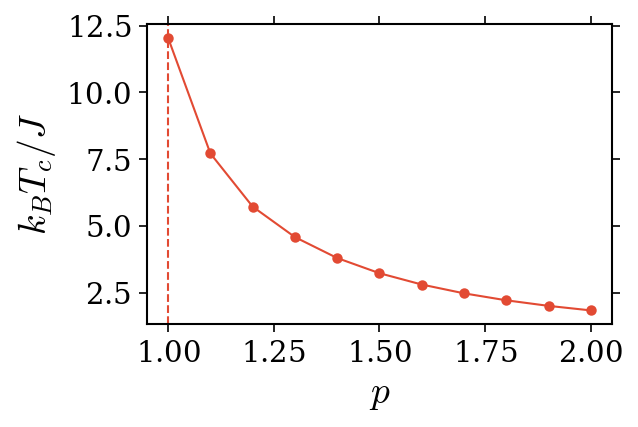

In [34]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()